##**Image-Sharpening ConvNet**

We are going to work with high-res images of a bunch of manga comicbook covers. Word of warning: high-res images means tons of pixels, which means tons of data in memory and big tensor operations. You'll see we can't do more than one image per batch in training! 

# Import Dataset

In [ ]:
import pandas as pd
from google.colab import files
import io

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The shape if each image is (585, 414, 3).


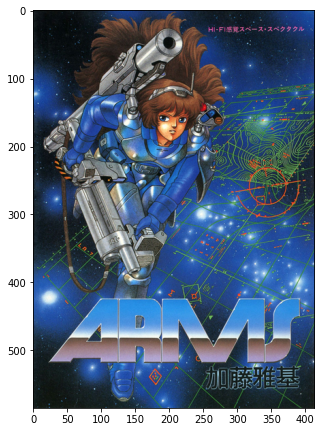

In [1]:
import numpy as np
import glob
from PIL import Image 
import matplotlib.pyplot as plt

image_list = []
for file in glob.glob("/content/drive/My Drive/Teaching/Courses/BA 865/Pre-Release/Week 5/datasets/manga_low/*"):
#for file in glob.glob("datasets/manga109/*"):
    im=Image.open(file)
    image_list.append(np.divide(np.array(im),255))

dpi = 80
  
height, width, depth = image_list[0].shape
figsize = width / float(dpi), height / float(dpi)

print(f'The shape if each image is {image_list[0].shape}.')

plt.figure(figsize=figsize)
plt.imshow(image_list[0])
plt.show()

#*Optional: Dataset Augmentation.*

With image data, it's pretty straight forward for us to synthesize new training examples by copying and then randomly manipulating the images we've already got!

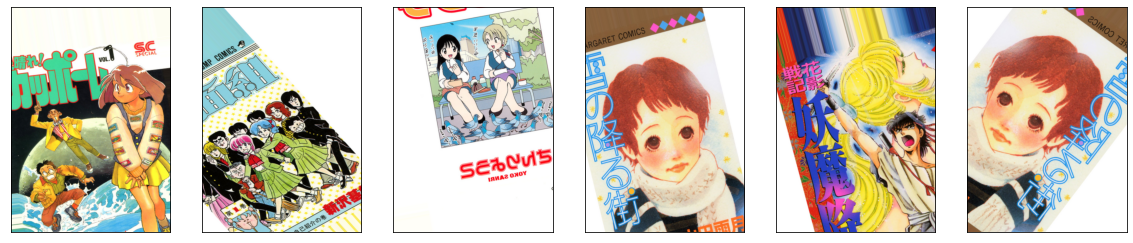

We now have a total of 428 images.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# First, 'train' the image data generator on our sample.
datagen.fit(image_list)

# Now we create the iterator... we can keep pulling new randomly transformed pictures out of this forever. 
image_batches = datagen.flow(np.stack(image_list,axis=0), batch_size=30)

n = 5
plt.figure(figsize= (20,10))

q = 0
for i,batch in enumerate(image_batches):
    for j, image in enumerate(batch): 
        if j == 1: 
            # Only plot the first 6 photos.
            if i <= 5:
                ax = plt.subplot(1, 6, i+1)
                plt.imshow(tf.keras.utils.array_to_img(image))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        
        # The iterator outputs image data with pixel values between 0-1; we are using values between 0-255 elsewhere.
        # We need to make the pixel values align.
        image_list.append(np.multiply(image,255))

    # Telling the script to stop asking for new images after several batches.
    if q > 10:
      break

    q += 1    

plt.show()

print(f'We now have a total of {len(image_list)} images.')

Lastly, let's make our X's now; the pixellated versions of the high resolution images.

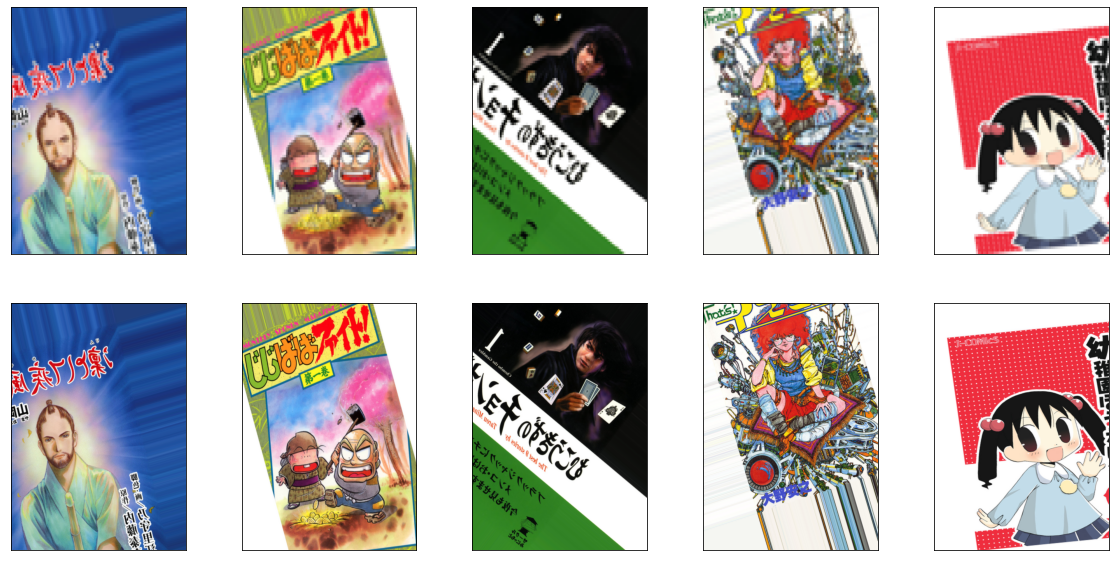

In [3]:
import tensorflow as tf
import numpy as np

image_L_list = []
pixelated_list = []
pixelated_L_list = []

# This part determines how difficult the problem is.
# If we downsample too much, there's not enough signal left in the data to recover the original.
# Try this with downsampling to 100x100 or even lower. The model won't be able to solve the problem.
for image in image_list:
  image = Image.fromarray(np.multiply(image,255).astype('uint8'))
  
  # First, get the Luminance value from the original RBG image (the Y in the three YCrCb signals.)
  image_L = image.convert('L')
  image_L = tf.keras.utils.img_to_array(image_L)
  image_L_list.append(image_L)
    
  # Next, make the pixelated version of the original image.
  image_tiny = image.resize((100,100))    # resize it to a tiny size
  pixelated = image_tiny.resize(image.size,Image.NEAREST)   # scale it back up
  pixelated_L = pixelated.convert('L')
  
  pixelated_RGB = pixelated_L.convert('RGB')
  
  # Store the pixelated photo.
  pixelated = tf.keras.utils.img_to_array(pixelated)
  pixelated_list.append(pixelated)
  
  # Then, store the luminence value of the pixelated photo (we will pull out the CbCr channels later and upscale them to create final output photos)
  pixelated_L = tf.keras.utils.img_to_array(pixelated_L)
  pixelated_L_list.append(pixelated_L)

# We will put these into NumPy arrays for use in our NN later.
pixelated_array = np.stack(pixelated_list, axis=0)
pixelated_L_array = np.stack(pixelated_L_list, axis=0)
image_L_array = np.stack(image_L_list, axis=0)
image_array = np.stack(image_list, axis=0)

# Let's plot the first 5 pairs of training images and their labels (in RGB).
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(tf.keras.utils.array_to_img(pixelated_list[i+110]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(tf.keras.utils.array_to_img(image_list[i+110]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# Create Our Neural Network

Now, we just need to create a model that takes the pixelated image as input, and tries to predict the original. 

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from keras import backend as K

# These are both custom loss functions we can define that are appropriate for measuring differences between to pictures.
def psnrLoss(y_true, y_pred, max_pixel=255.0):
    psnr = tf.image.psnr(y_true,y_pred,max_val=max_pixel)
    return psnr

def ssim_msLoss(y_true, y_pred,max_val=255.0):
    ssim = tf.image.ssim_multiscale(y_true,y_pred,max_val)
    return ssim

conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same"
    }

# Take the 3-dimensional input tensor, apply a bunch of convolutions, then go to a dense layer. 
# One skip connection from inputs to the final dense layer. 
inputs = keras.Input(shape=(height, width, 1))
x = layers.Conv2D(128, 5, **conv_args)(inputs)
x = layers.Conv2D(128, 3, **conv_args)(inputs)
x = layers.Conv2D(64, 5, **conv_args)(x)
x = layers.Conv2D(64, 3, **conv_args)(x)
x = layers.Conv2D(32, 3, **conv_args)(x)
x = layers.Conv2D(8, 3, **conv_args)(x)
x = layers.Conv2D(8, 3, **conv_args)(x)
#x = layers.Concatenate()([x,inputs])
outputs = layers.Conv2D(1, 3, **conv_args)(x)

# Stick all the pieces together. 
model = keras.Model(inputs, outputs)

# Compile the model - note, PSNR is positive signal to noise ratio (a loss metric that is specific to assessing image quality)
model.compile(optimizer="adam", loss='mse', metrics=[psnrLoss])

If we need to clear some memory... 

In [ ]:
import gc 

del image_list, pixelated_list, pixelated_L_list, image_L_list
gc.collect()

In [ ]:
K.clear_session()
del model
gc.collect()

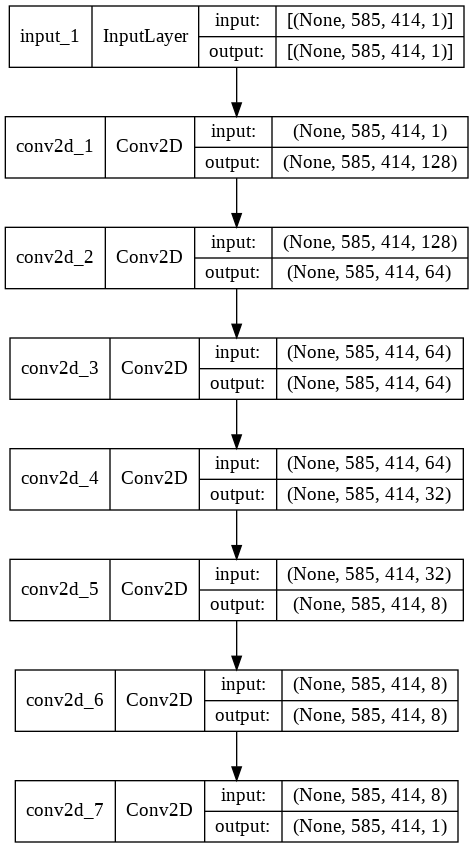

In [21]:
keras.utils.plot_model(model, show_shapes=True)

Okay, let's try fitting this model... 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /logs

In [ ]:
history = model.fit(pixelated_L_array,image_L_array,batch_size=1,epochs=50, validation_split=0.2,callbacks=keras.callbacks.TensorBoard(log_dir='/logs'))

And, let's plot the loss over epochs... 

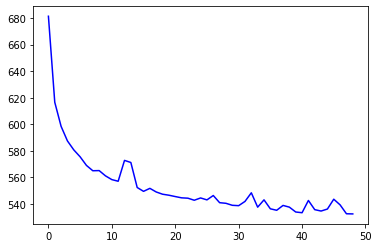

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][1:],c="b")
plt.show()

Let's spit out some of the predictions from this model to see how well it works...

In [17]:
## This can be done mouch more cleanly. Write a function to take an RGB image, parse out Y, Cr, Cb. 
def predict_to_RGB(pixelated_array,pixelated_L_array):

  # First, get the predicted luminosity signal based on each pixelated photo's luminosity signal.
  predicted_L_array = model.predict(pixelated_L_array)
  
  result = []
  for i in range(pixelated_array.shape[0]):
      
      # Next, for each pixelated photo, strip out its Cb and Cr signals for reuse in the final sharpened photo.
      ycbcr = tf.keras.utils.array_to_img(pixelated_array[i]).convert("YCbCr")
      L, cb, cr = ycbcr.split()

      # Convert the predicted L signal from numpy array format into a PIL Image. 
      predicted_L = Image.fromarray(np.uint8(predicted_L_array[i][:,:,0]), mode="L")

      # Combine the PIL luminosity Image with the PIL Cb and Cr images, and convert the result back into RBG format for display. 
      result.append(Image.merge("YCbCr", (predicted_L, cb, cr)).convert("RGB"))
  
  return np.stack(result,axis=0)

In [23]:
sharpened_array = predict_to_RGB(pixelated_array[:15], pixelated_L_array[:15])

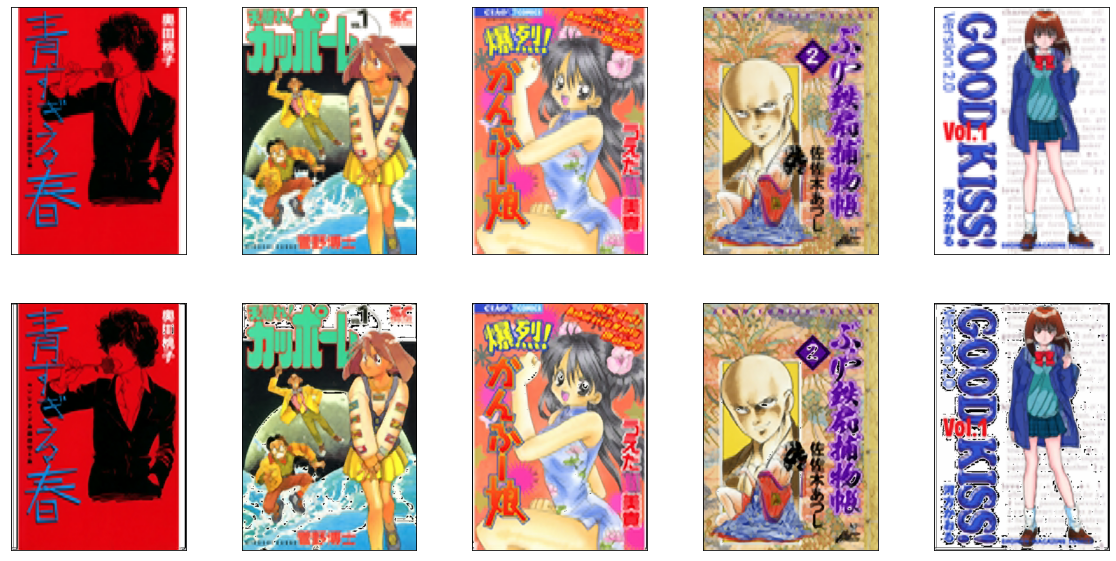

In [24]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow((pixelated_array[i+5]).astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow((sharpened_array[i+5]).astype('uint8'))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()